# Laplacian Associative Memory (LAM) - Gaussain

[Multiscale representations of community structures in attractor neural networks](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8412329/pdf/pcbi.1009296.pdf) (2021)

In [1]:
import sys
sys.path.append('..')

In [2]:
import torch, PIL.Image, imageio
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from nn_torch import LAM
import libtools

---

#### IMAGE & FAST FOURIER

In [4]:
# Gaussain
ext = 25
N = 100
X, Y = np.meshgrid(np.linspace(-ext, ext, N), np.linspace(-ext, ext, N))

sigmaX = 3
sigmaY = 8
img = np.exp(-(X**2)/(2*sigmaX**2) - (Y**2)/(2*sigmaY**2))

In [5]:
print('Image:', img.shape)
print('min:', f"{img.min():.2f}", 'max:', f"{img.max():.2f}")

Image: (100, 100)
min: 0.00 max: 1.00


---

In [6]:
src = libtools.preference_map(16, 25, img.shape[0]) # x2 power of spatial frequency FFT
# np.save('../data/mat/SOM_orient_v2.npy', src)
# src = np.load('../data/mat/SOM_orient_v2.npy')

print('Map:', src.shape)
print('min:', f"{src.min():.2f}", 'max:', f"{src.max():.2f}")

Map: (100, 100)
min: 0.00 max: 6.28


---

In [7]:
step = 12

pad = int(step/2)
pad_im = np.pad(img, pad, mode='constant', constant_values=0)
features = np.zeros_like(pad_im)

for i in range(src.shape[0]):
    for j in range(src.shape[1]):
        rad = src[i][j] - np.pi # -π and π
        deg = np.rad2deg(rad)
        kernel = libtools.gabor_filter(1, 10, deg, step) # Orientation
        patch = pad_im[i:i+step, j:j+step]
        features[int(i+pad),int(j+pad)] = np.sum(patch * kernel) # Firing Rate / Response

features = features[pad:pad+src.shape[0],pad:pad+src.shape[1]]
features[features<=0] = 0 # Rectify
features /= np.max(features)

In [8]:
print('Features:', features.shape)
print('min:', f"{features.min():.2f}", 'max:', f"{features.max():.2f}")

Features: (100, 100)
min: 0.00 max: 1.00


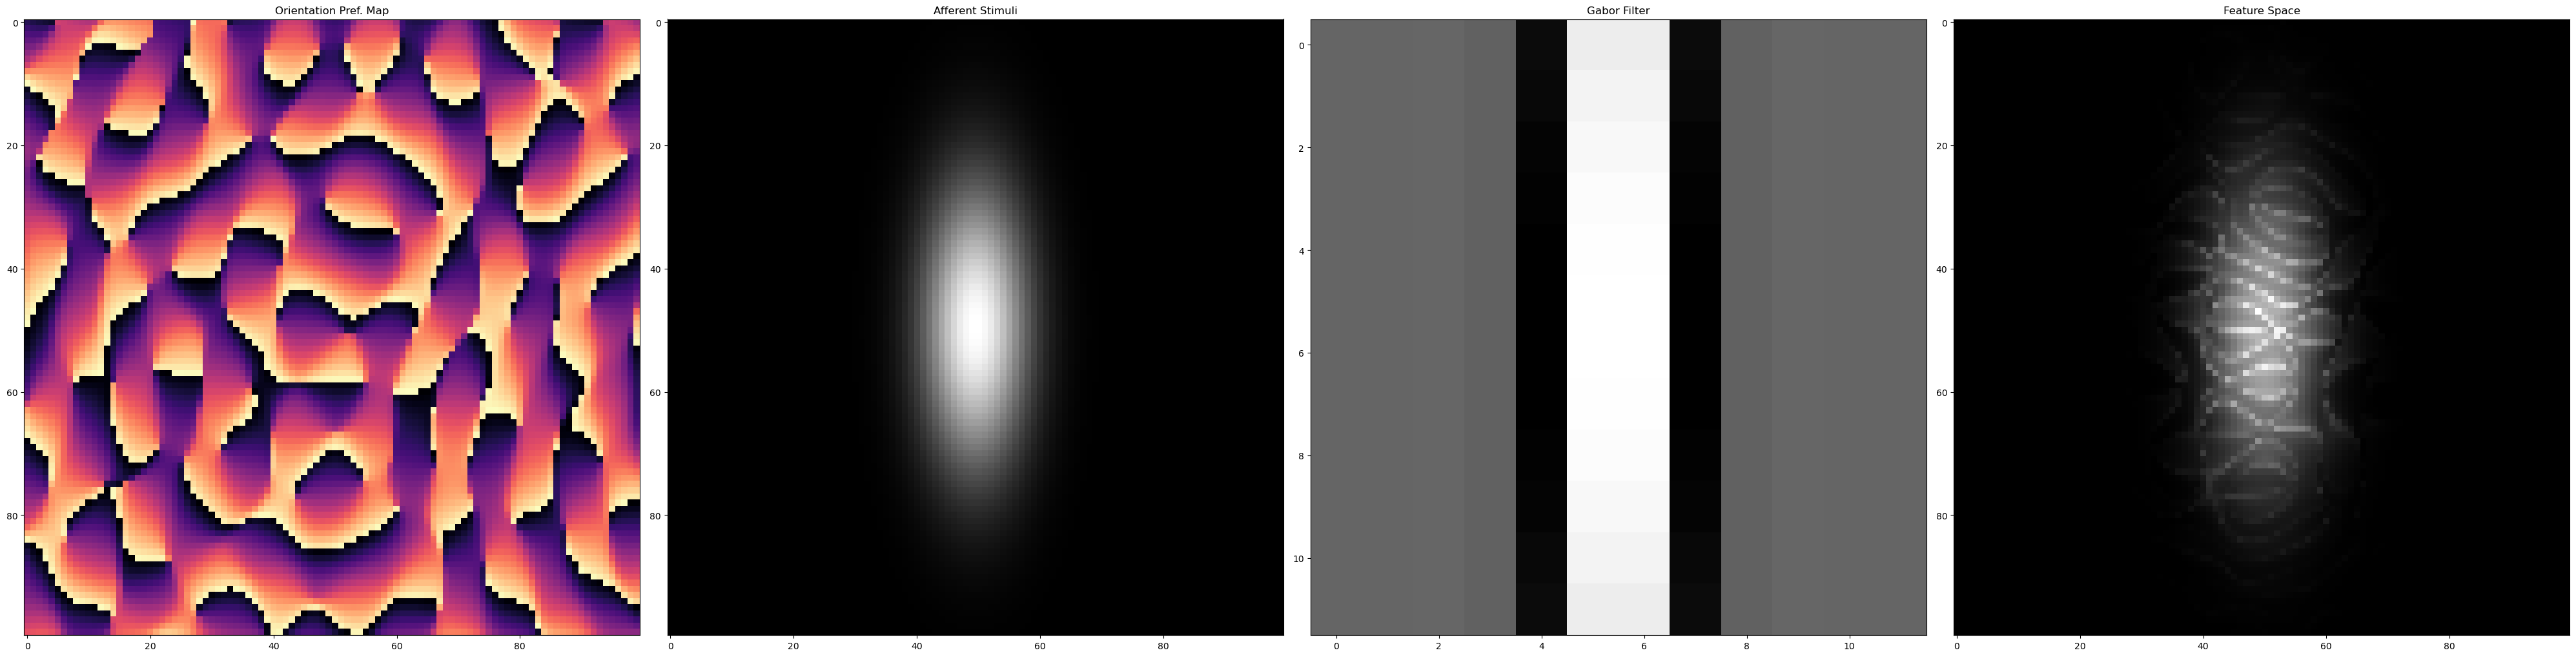

In [9]:
plt.figure(figsize=(40,10))
plt.subplot(1,4,1)
plt.imshow(src, 'magma')
plt.title('Orientation Pref. Map')

plt.subplot(1,4,2)
plt.imshow(img, 'gray')
plt.title('Afferent Stimuli')

plt.subplot(1,4,3)
plt.imshow(libtools.gabor_filter(1,10,0, samples=12), 'gray')
plt.title('Gabor Filter')

plt.subplot(1,4,4)
plt.imshow(features, 'gray')
plt.title('Feature Space')
plt.tight_layout()

---

---

### HYPER-PARAMETERS

In [10]:
N = 128**2                              # Units | Default: 30000
prob = 0.1                              # Sparsity
eta = 0.01                              # Epsilon / Learning rate
simlen = 3000                           # Steps / Epochs
gamma = 0.6                             # Inhibition ratio
norm_mode = 'asym'                      # Asymmetric Normalisation
alpha = -0.9                            # Ratio between local and global inhibition
P = src.shape[0] * src.shape[1]         # N Nodes

sigmaX = 1e-5                           # Spatial Gaussian Scale
sigmaA = 0.1                            # Angular Gaussian Scale

# Init condition (Center cell/pixel)
start_node = int(int(src.shape[0]/2) * src.shape[1] + int(src.shape[0]/2))

print('Nodes:', N)
print("Neurons:", P)
print('Start node:', start_node)
print(f"{P * 0.138:.2f} point attactors")

Nodes: 16384
Neurons: 10000
Start node: 5050
1380.00 point attactors


---

### COMPUTE

In [11]:
W = libtools.construct_SLAM(src, sigmaX, sigmaA) # Correlation Matrix

In [12]:
# Convert to tensor
img = torch.from_numpy(img).float()
features = torch.from_numpy(features).float()
W = torch.from_numpy(W).float()

In [13]:
graph = LAM(N, P, prob, W, gamma, "asym") # Decompose Weights

In [14]:
# Afferent initial condition
I = np.zeros_like(graph.xi)
for node in range(graph.xi.shape[1]):
    state = (graph.xi[:, node].clone() * 2) - 1
    I[:,node] = state * features.flatten()[node]

Inorm = np.sum(I, axis=1) * 1/graph.xi.shape[1]
act = libtools.boltzmann_prob(Inorm, 0.015)

print("Sparsity:", np.sum(act/np.size(act)))

init_state = torch.from_numpy(act).float()

Sparsity: 0.0662841796875


In [15]:
m_log, p_log, e_log = graph.simulate_single(alpha, eta, simlen, start_node, init_state.clone()) # Simulate

Using feature-based initial condition


100%|██████████| 3000/3000 [02:22<00:00, 21.02it/s]


In [16]:
m = m_log[-1,:].clone()
# m[start_node] = np.mean(np.delete(m, start_node))

Nactive = torch.mean(torch.sum((m > 0.5*m.max()).float() * (m > 0.0), dim=0))
print("Maximum overlap:", m.max())
print("Number of patterns:", Nactive)

Maximum overlap: tensor(0.0014)
Number of patterns: tensor(288.)


---

### PLOT

In [17]:
# HSV2RGB
m_norm = m + abs(m.min())
m_norm /= m_norm.max()

hsv_pattern = libtools.grade(src/(2*np.pi), 1.0, m_norm.reshape(src.shape))
hsv_features = libtools.grade(src/(2*np.pi), 1.0, features.reshape(src.shape))

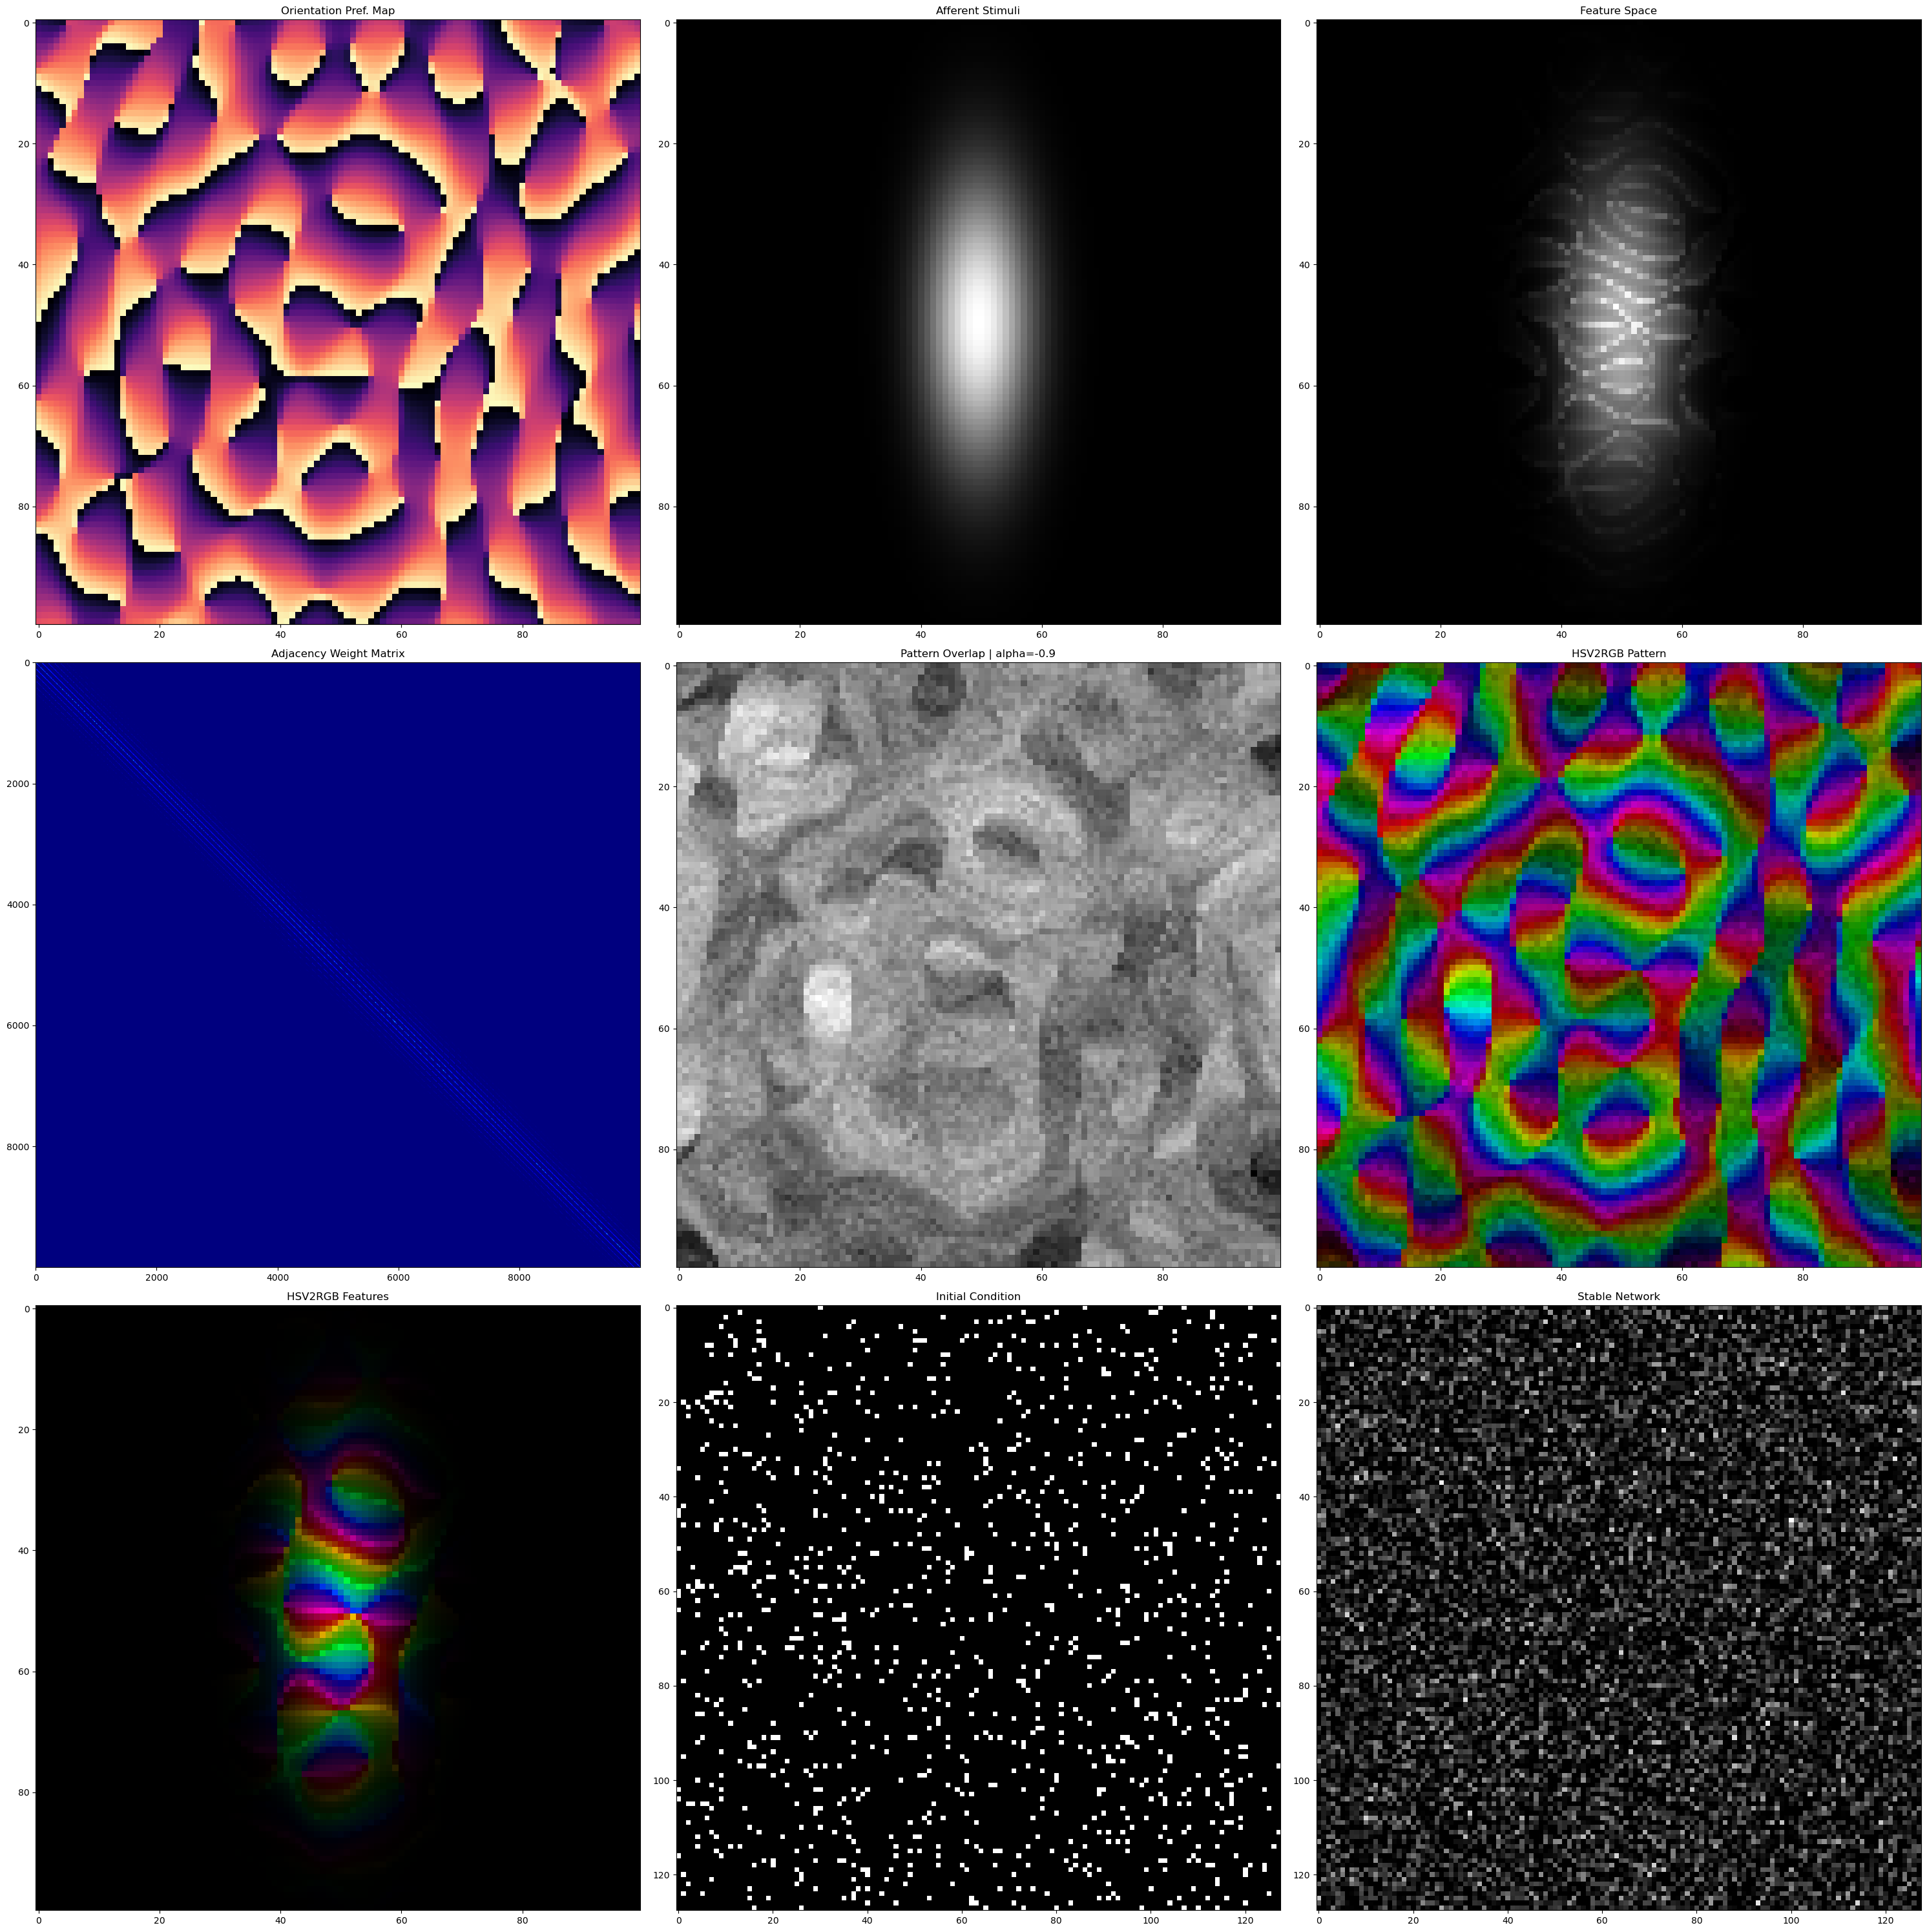

In [18]:
plt.figure(figsize=(30,30))
plt.subplot(3, 3, 1)
plt.imshow(src, 'magma')
plt.title('Orientation Pref. Map')

plt.subplot(3, 3, 2)
plt.imshow(img, 'gray')
plt.title('Afferent Stimuli')

plt.subplot(3, 3, 3)
plt.imshow(features, 'gray')
plt.title('Feature Space')

plt.subplot(3, 3, 4)
plt.imshow(W, 'jet')
plt.title('Adjacency Weight Matrix')

plt.subplot(3, 3, 5)
plt.imshow(m.reshape(src.shape), 'gray')
plt.title("Pattern Overlap | alpha=" + str(alpha))

plt.subplot(3, 3, 6)
plt.imshow(hsv_pattern)
plt.title("HSV2RGB Pattern")

plt.subplot(3, 3, 7)
plt.imshow(hsv_features)
plt.title("HSV2RGB Features")

plt.subplot(3, 3, 8)
dim = int(N**0.5)
plt.imshow(init_state.reshape([dim,dim]), 'gray')
plt.title("Initial Condition")

plt.subplot(3, 3, 9)
plt.imshow(graph.x.reshape([dim,dim]), 'gray')
plt.title("Stable Network")
plt.tight_layout()